<a href="https://colab.research.google.com/github/shantam-8/ML-Materials-Individual-Project/blob/main/Individual_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Individual Project

In [2]:
import numpy as np

# Insert your values
Name = "Shantam Gilra" # Replace with your name
CID = 1878023 # Replace with your College ID (as a numeric value with no leading 0s)

# Set a random seed using the CID value
CID = int(CID)
np.random.seed(CID)

# Print the message
print("This is the work of " + Name + " [CID: " + str(CID) + "]")

This is the work of Shantam Gilra [CID: 1878023]


## Problem statement

You have been assigned one dataset from the [list](https://matbench.materialsproject.org/Benchmark%20Info/matbench_v0.1/) on [MatBench](https://matbench.materialsproject.org). You should state what problem you are trying to solve and comment on the best-performing model in the benchmark.

## 1.0 Libraries Used

In [3]:
training_mode = True

In [4]:
# Installation of libraries
if training_mode == False:
  !pip install matminer=="0.9.0" --quiet
  !pip install pymatgen=="2023.09.25" --quiet

!pip install elementembeddings --quiet
!pip install xgboost --quiet
!pip install lightgbm --quiet

!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.7/807.7 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 35.2 

In [5]:
# Import of modules
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation with DataFrames


if training_mode == False:
  import matminer  # Materials informatics
  from matminer.datasets.dataset_retrieval import load_dataset  # Load materials datasets
  from pymatgen.core import Structure, Composition  # Materials analysis for crystal structures
from elementembeddings.core import Embedding


import plotly.express as px


# To make the model run faster
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.0 Data Preparation



In [6]:
if training_mode == False:
  df = load_dataset("matbench_expt_gap")
else:
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Main Data.csv")

df.head(10)

,composition,gap expt
0,Ag(AuS)2,0.00
1,Ag(W3Br7)2,0.00
2,Ag0.5Ge1Pb1.75S4,1.83
3,Ag0.5Ge1Pb1.75Se4,1.51
4,Ag2BBr,0.00
5,Ag2BiO3,0.00
6,Ag2GeS3,1.98
7,Ag2GeSe3,0.90
8,Ag2HgI4,2.47
9,Ag2Mo(I2O7)2,3.06


In order to correctly featurise the dataset given, different featurisers from Maminer and Element Embeddings were used. It was likely that different statistical elements (minimum, maximum, range, mean, avg_dev and mode) of different Magpie properties would be important to accurately predict the band gap. Hence, all statistical elements of all Magpie properties were added to the featurised dataset. This was followed by an addition to one-hot encoded columns of atomic structure and properties like the band center.

### 2.1 Data Featurisation

In [7]:
if training_mode == False:

  # Featurising df
  from elementembeddings.composition import composition_featuriser, CompositionalEmbedding
  from matminer.featurizers.composition.composite import ElementProperty
  from matminer.featurizers.composition.element import BandCenter


  # Adding fractional composition column to main database.
  df['fractional_composition'] = df['composition'].apply(lambda x: Composition(x).fractional_composition)

  # Featurising based on magpie data using fractional composition.
  df_featurised = ElementProperty.from_preset(preset_name="magpie").featurize_dataframe(df, col_id='fractional_composition')

  # Featurising by adding one-hot collumns of each compound
  composition_df = composition_featuriser(df_featurised["composition"], embedding="atomic", stats=["sum"])
  df_featurised = pd.concat([df_featurised, composition_df], axis=1)

  # # Featurising by adding one-hot collumns of each compound
  # bandcenter_df = BandCenter().featurize_dataframe(df, col_id='fractional_composition', ignore_errors=True)
  # df_featurised = pd.concat([df_featurised, bandcenter_df], axis=1)

  # Adding column that includes number of atoms in each compound
  df_featurised["num_atoms"] = df["composition"].apply(lambda x: CompositionalEmbedding(x, "magpie").num_atoms)

  # Drop non-featurised columns
  df_featurised = df_featurised.drop(["composition", "gap expt", "fractional_composition", "formula"], axis=1)

else:
  df_featurised = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Featurised Data.csv")


df_featurised

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,sum_Ds,sum_Rg,sum_Cn,sum_Nh,sum_Fl,sum_Mc,sum_Lv,sum_Ts,sum_Og,num_atoms
0,16.0,79.0,63.0,47.400000,25.280000,16.0,65.0,88.0,23.0,74.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00
1,35.0,74.0,39.0,46.714286,15.619048,35.0,51.0,95.0,44.0,81.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.00
2,16.0,82.0,66.0,36.275862,23.552913,16.0,65.0,88.0,23.0,83.482759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.25
3,32.0,82.0,50.0,46.206897,17.388823,34.0,65.0,89.0,24.0,84.034483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.25
4,5.0,47.0,42.0,33.500000,14.250000,47.0,65.0,95.0,30.0,74.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,7.0,73.0,66.0,26.800000,23.760000,7.0,44.0,82.0,38.0,67.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00
4600,40.0,52.0,12.0,46.000000,6.000000,40.0,44.0,90.0,46.0,67.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.00
4601,8.0,40.0,32.0,23.000000,8.500000,22.0,43.0,87.0,44.0,54.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00
4602,9.0,40.0,31.0,14.500000,8.250000,9.0,43.0,93.0,50.0,80.625000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.00


It was not clear as to which features are important and training models with non-important features would increase computation costs and would decrease the model's accuracy. Hence, a preliminary Random Forest regressor was trained on the whole dataset to derive the feature importances of all features. This was represented in two different ways - a bar chart containing the feature importances of different features and a plot of one decision tree of the random forest ensemble.

In [8]:
from sklearn.ensemble import RandomForestRegressor

# Define the features we want in the DataFrame
feature_cols = [col for col in list(df_featurised.columns) if col != "formula"]

# Get an array of the features
prelim_X = df_featurised[feature_cols]

# Get an array of the target variable
y = df["gap expt"]

# Training a preliminary random forest regressor to understand the importance of different features
prelim_rf = RandomForestRegressor()
prelim_rf.fit(prelim_X, y)

RandomForestRegressor()

In [9]:
# Load the atomic data
atomic_feature_labels = Embedding.load_data('atomic').feature_labels
one_hot_columns = ["sum_" + a for a in atomic_feature_labels]

# Get index of all one-hot encoded element columns to sum their feature importances
imp = prelim_rf.feature_importances_
feature_col = prelim_X.columns

elem_indices = [np.where(np.isin(prelim_X.columns, one_hot_columns))[0]]
elem_imp = imp[np.where(np.isin(prelim_X.columns, one_hot_columns))[0]].sum()

# Removing individual element contributions and adding them together
imp = np.delete(imp, elem_indices)
imp = np.append(imp, elem_imp)

# Removing individual element columns and adding "Elements"
feature_col = np.delete(feature_col, elem_indices)
feature_col = np.append(feature_col, "Elements")

# Sorting both arrays based on descending order of importances
sort_inds = imp.argsort()
imp = imp[sort_inds[::-1]]
feature_col = feature_col[sort_inds[::-1]]

# Plot the bar chart containing the feature importances of different features
fig = px.bar(x = feature_col, y = imp,
             labels={"x": "Preliminary Feature Columns", "y": "Feature Importances"},
             title="Feature Importance Bar Chart")

fig.update_xaxes(tickfont=dict(size = 6))
fig.show()

The chart signifies the importance of added features like the one-hot encoded atomic data and band center. As seen, all features after "MagpieData range GSmagmom" have very less importance values (<0.001) and would be removed.

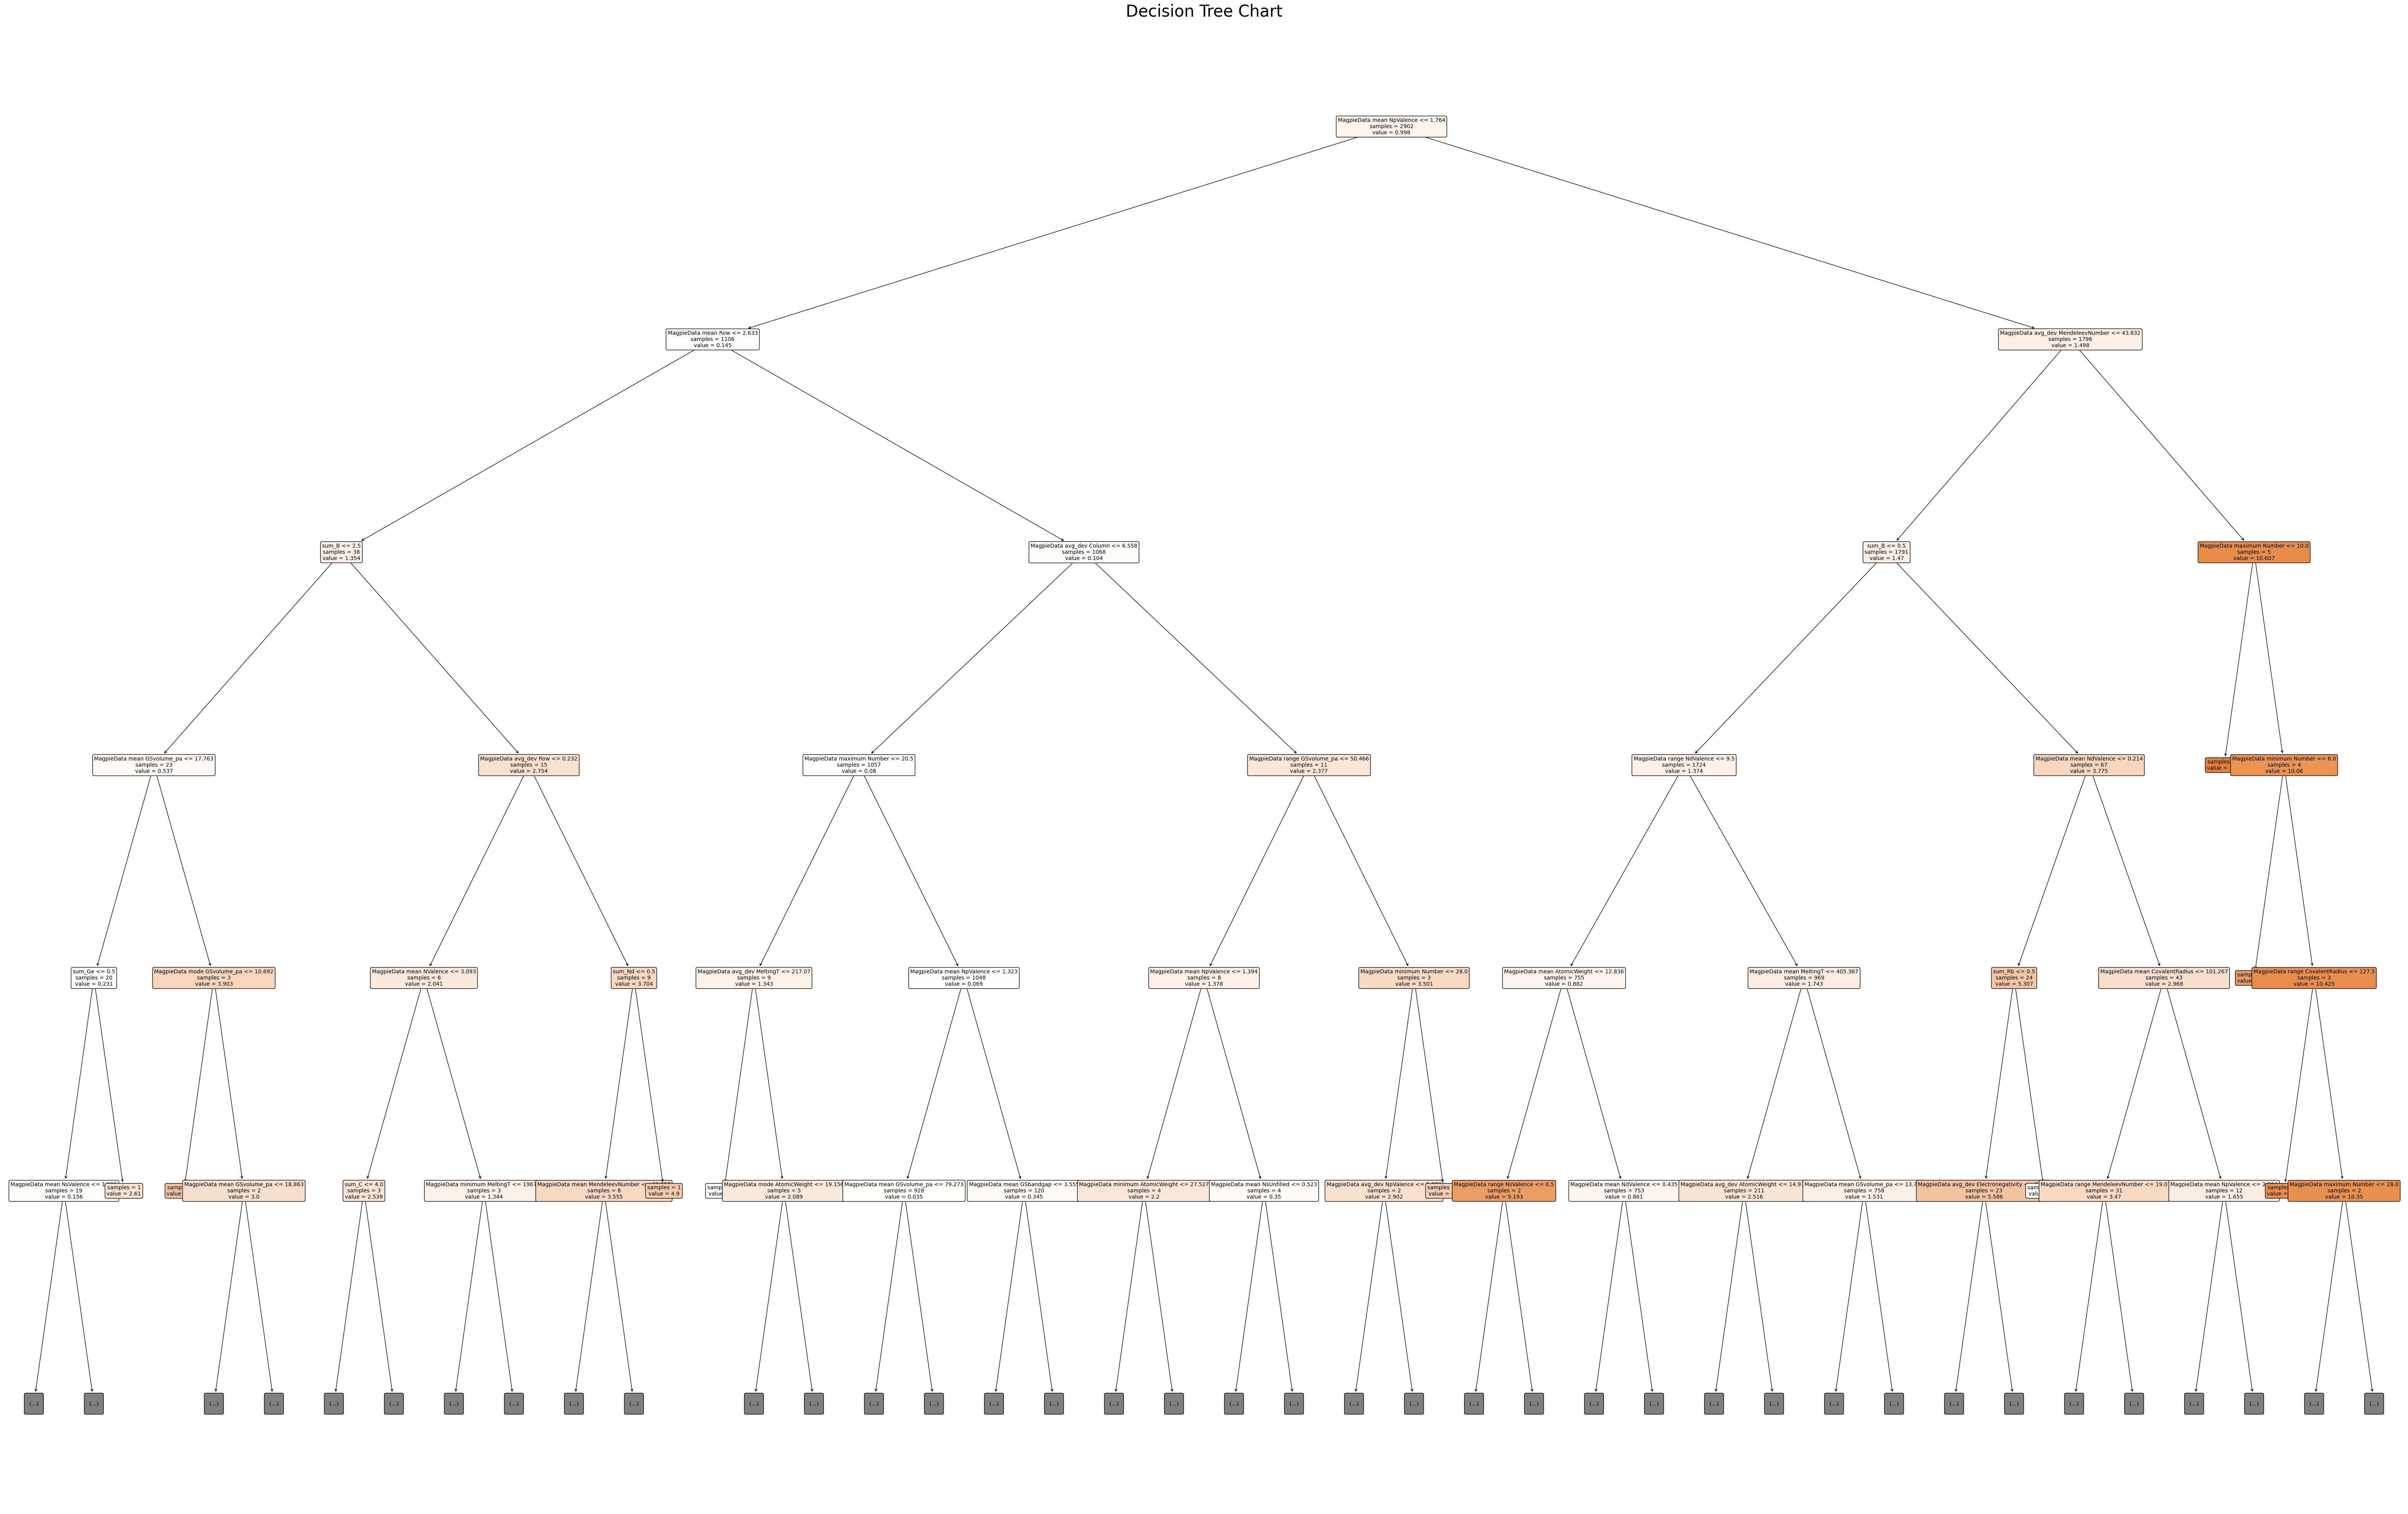

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

# Plot a chart of one decision tree in the random forest ensemble (click on the graph to zoom it)
plt.figure(figsize=(80, 50))
_ = tree.plot_tree(prelim_rf.estimators_[0], max_depth = 5, feature_names = df_featurised.columns, filled = True, rounded = True, fontsize = 10, impurity = False)
plt.title("Decision Tree Chart", fontsize = 30)
plt.show()

While the chart further amplified the importance of "MagpieData mean NpValence", it also showed the high extremity (darker shades of the box depict higher extremity) of compositions specific properties. This indicates that the predicted values of some compositions would have high deviations from the actual values.

While these compositions could be filtered out of the training and testing datasets, these were still left in the dataset as it can be possible that other decision trees in the ensemble or other models can accurately predict the band gap.

In [10]:
# Remove all column values in the featurised dataset with a lower feature importance than "MagpieData range GSmagmom"
X = df_featurised.drop(feature_col[np.where(feature_col == "MagpieData range GSmagmom")[0][0] + 1:], axis=1)

The final dataset has 4604 compositions with 184 features.

### 2.2 Data Analysis

The distribution of band gap values was then explored in the context of the features by reducing the number of dimensions to three using PCA.

In [ ]:
from sklearn.decomposition import PCA

# Performing a 3 axes PCA on the featurised dataset
pca = PCA(n_components=3)
transformed_data = pca.fit_transform(X)

# Plotting 3D scatter plot
fig = px.scatter_3d (x = transformed_data[:, 0], y = transformed_data[:, 1], z = transformed_data[:, 2], color = df["gap expt"][X.index],
                     labels = {"x": "PCA X-axis", "y": "PCA Y-axis", "z": "PCA Z-axis", "color": "Band Gap"},
                     title = "PCA 3D Scatter Plot")

fig.update_layout(scene_camera = dict(eye = dict(x=0, y=0, z=1.5)))
fig.show()

The 3D Scatter plot is displayed on a specific camera angle to depict the relative postion of compositions having high and low band gaps - as seen, high band gaps are typically form a cluster in the left region. While the PCA did not have any information regarding the band gap, it was able to loosely seperate the high and low band gap compounds - hence, justifying the validity of the featurised dataset.

However, the 3D scatter plot also indicates the dominance of compositions with a low band gap. This distribution is further explored using a histogram.

In [11]:
# Plotting histogram of Band Gaps
fig = px.histogram(x = df["gap expt"],
                   nbins = 12,
                   marginal = "box",
                   labels = {"x": "Band Gap"},
                   title = "Distribution of Band Gaps")

fig.show()

Due to the comparatively high number of low band gaps as seen by the box plot and graph, the training and testing datasets can be split using a stratified split rather than a random split. This may ensure that the model will be more robust and accurate. However, to create preliminary models, a random split will be used.

## 3.0 Training and Testing

### 3.1 Benchmark Models

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xg
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

from plotly.subplots import make_subplots
import plotly.graph_objects as go


# # Standard scaling of featurised dataset for different models.
# scaler = StandardScaler()
# scaled_X = scaler.fit_transform(X)

# Standard scaling of featurised dataset for different models.
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# Target Values
y = df["gap expt"]

# Splitting train and test values
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state=42)

In [13]:
def models_eval (models_dict, cv = 5, show_graph = False, cols = 3):

  # Setting up DataFrame object to hold data
  metrics_df = pd.DataFrame(columns = ["Model Name","CV RMSE (eV)", "CV R2", "CV mean MAE", "CV std MAE", "Test RMSE (eV)", "Test R2", "Test MAE", "Time (s)"])

  # Initiating figure if show_graph = True
  if show_graph:
    cols = cols
    rows = len(models_dict) // cols + (1 if len(models_dict) % cols != 0 else 0)

    fig = make_subplots(rows = rows,
                      cols = cols,
                      subplot_titles = list(models_dict.keys()))

  # Loop to run different models
  for ind, m in enumerate(models_dict):

    model = models_dict[m][0]
    X_train = models_dict[m][1]
    X_test = models_dict[m][2]
    y_train = models_dict[m][3]
    y_test = models_dict[m][4]

    model.fit(X_train, y_train)

    cv_scores = cross_validate(model, X_train, y_train, cv = cv, scoring = ('r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'), n_jobs = -1)
    y_pred = model.predict(X_test)

    # Testing Metrics
    test_rmse = root_mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)

    metrics_list = [m,
                    np.mean(abs(cv_scores["test_neg_root_mean_squared_error"])),
                    np.mean(abs(cv_scores["test_r2"])),
                    np.mean(abs(cv_scores["test_neg_mean_absolute_error"])),
                    np.std(abs(cv_scores["test_neg_mean_absolute_error"])),
                    test_rmse,
                    test_r2,
                    test_mae,
                    np.mean(cv_scores["fit_time"])]

    # Storing metrics in metrics_df
    metrics_df.loc[len(metrics_df)] = metrics_list

    # Displaying graph if show_graph = True
    if show_graph:
      fig.add_trace(
          go.Scatter(x = y_test, y = model.predict(X_test), mode="markers"),
          col = ind % cols + 1,
          row = int(str((ind/cols) + 1)[0]),
          )

      fig.add_trace(
        go.Scatter(x = y_test, y = y_test, mode = "lines", line = dict(color = "black"), hoverinfo = "none"),
        col = ind % cols + 1,
        row = int(str((ind/cols) + 1)[0])
        )

      fig.update_xaxes(title_text="Actual Values", col = ind % cols + 1, row = int(str((ind/cols) + 1)[0]))
      fig.update_yaxes(title_text="Predicted Values", col = ind % cols + 1, row = int(str((ind/cols) + 1)[0]))


  if show_graph:
    fig.update_layout(height = 500 * rows, width = 500 * cols, showlegend = False, title_text="Model Evaluation")
    fig.show()

  return metrics_df

In [ ]:
models_dict = {
    "Random Forest Regressor" : [RandomForestRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "Support Vector Machine Regressor" : [SVR(), X_train, X_test, y_train, y_test],
    "XG Boost" : [xg.XGBRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "Kernal Ridge" : [KernelRidge(), X_train, X_test, y_train, y_test],
    "KNN Regressor" : [KNeighborsRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "LGBM Regressor" : [LGBMRegressor(n_jobs = -1, verbose = -1), X_train, X_test, y_train, y_test],
    "Gradient Boost Regressor" : [GradientBoostingRegressor(), X_train, X_test, y_train, y_test]
}

models_eval(models_dict, show_graph = True, cv = 10)

,Model Name,CV RMSE (eV),CV R2,CV MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,Random Forest Regressor,0.805075,0.681627,0.443679,0.859723,0.656341,0.446742,39.876877
1,Support Vector Machine Regressor,1.072827,0.439718,0.583262,1.066967,0.470687,0.601404,2.322253
2,XG Boost,0.793088,0.690325,0.442797,0.775576,0.720322,0.438308,2.733621
3,Kernal Ridge,1.078998,0.429984,0.744143,1.113830,0.423169,0.765920,1.535380
4,KNN Regressor,0.956881,0.548177,0.523289,1.027428,0.509190,0.536135,0.004926
5,LGBM Regressor,0.789245,0.693322,0.438962,0.786671,0.712262,0.434036,5.592400
6,Gradient Boost Regressor,0.862942,0.633401,0.537959,0.902690,0.621132,0.550007,11.610723


As seen by the above graphs and table, architecture of linear regression models like Kernal Ridge would not be suitable. Furthermore, the graphs indicate that all models are not able to predict Band Gap energy when its too high. This might be becuase there is not enough high Band Gap materials in the training set. In order to ensure this, a stratified split will be explored and compared with the normal split.

While hypertuning and evaluating different models, Root Mean Sqaure Error (RMSE) will be be given priority. This is done as RMSE particularly gives a high weight to large errors, ensuring that the models developed would be able to effectively reduce the error between the actual values and predicted values.  

### 3.2 Data Stratification

As mentioned in Section 2.2, the band gap data has an uneven distribution of data where most values tend to be closer to 0. Hence, data stratification is considered where clusters are decided by a KMeans clustering algorithm to enable stratification. This algorithm was particularly chosen as it allows a direct control in the number of clusters made - too less `(n_clusters = ~1)` or too more clusters `(n_clusters = ~10)` would make stratification obsolete.

Hence, to understand the ideal value for `n_clusters`, a loop was run to generate upto 10 clusters and understand its effect on the metrics of different models. In this case, `n_clusters = 1` creates benchmark models as no stratification happens. A `random_state` parameter was also set in `train_test_split` to ensure equal comparison between models created.

In [14]:
from sklearn.cluster import KMeans


if training_mode == True:
  strat_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/strat_df.csv")

else:
  strat_df = pd.DataFrame()

  for i in range(9):
    # Trying different clusters
    kmean_cluster = KMeans(n_clusters = i + 1).fit(pd.DataFrame(y))

    # Splitting train and test values
    strat_X_train, strat_X_test, strat_y_train, strat_y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state = 42, stratify = kmean_cluster.labels_)

    # Training all models
    models_dict = {
      "Random Forest Regressor" : [RandomForestRegressor(n_jobs = -1), strat_X_train, strat_X_test, strat_y_train, strat_y_test],
      "Support Vector Machine Regressor" : [SVR(), strat_X_train, strat_X_test, strat_y_train, strat_y_test],
      "KNN Regressor" : [KNeighborsRegressor(n_jobs = -1), strat_X_train, strat_X_test, strat_y_train, strat_y_test],
      "LGBM Regressor" : [LGBMRegressor(n_jobs = -1, verbose = -1), strat_X_train, strat_X_test, strat_y_train, strat_y_test],
      "XG Boost" : [xg.XGBRegressor(n_jobs = -1), strat_X_train, strat_X_test, strat_y_train, strat_y_test],
      "Gradient Boost Regressor" : [GradientBoostingRegressor(), strat_X_train, strat_X_test, strat_y_train, strat_y_test]
      }

    metrics_df = models_eval(models_dict, cv = 10, show_graph = False)
    metrics_df["Stratify"] = i + 1

    strat_df = pd.concat([strat_df, metrics_df])

strat_df

,Model Name,CV RMSE (eV),CV R2,CV MAE,Test RMSE (eV),Test R2,Test MAE,Time (s),Stratify
0,Random Forest Regressor,0.808572,0.684768,0.442068,0.786950,0.688745,0.429465,42.231924,1
1,Support Vector Machine Regressor,1.098871,0.425022,0.599749,0.996932,0.500480,0.547875,2.056461,1
2,KNN Regressor,0.970557,0.546870,0.526130,0.964652,0.532304,0.504966,0.005399,1
3,LGBM Regressor,0.800765,0.692378,0.439248,0.728731,0.733095,0.405856,9.838585,1
4,XG Boost,0.819317,0.676634,0.454135,0.767207,0.704166,0.424127,2.933824,1
5,Gradient Boost Regressor,0.875055,0.632002,0.544770,0.842063,0.643621,0.518757,11.446111,1
6,Random Forest Regressor,0.837333,0.656677,0.450699,0.805271,0.704734,0.443109,35.969447,2
7,Support Vector Machine Regressor,1.054091,0.459323,0.576854,1.172742,0.373770,0.638796,1.906046,2
8,KNN Regressor,0.988471,0.519912,0.534237,0.984651,0.558538,0.529774,0.005105,2
9,LGBM Regressor,0.812185,0.676587,0.440064,0.779446,0.723369,0.431038,13.512303,2


In [ ]:
# strat_df.to_csv("/content/drive/MyDrive/Colab Notebooks/strat_df.csv", index = None)

In [15]:
## Plotting RMSE values
fig = px.line(strat_df, x = "Stratify", y = ["CV RMSE (eV)", "Test RMSE (eV)"], color="Model Name", markers=True)

# Changing line types
for i, trace in enumerate(fig.data):
  if i % 2 == 1:
    trace.line.dash = "dash"

# Create traces for custom legend (solid and dash lines)
solid_trace = go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='black', width=2, dash='dash'), name = "Test RMSE (eV)")
dash_trace = go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='black', width=2), name = "CV RMSE (eV)")
fig.add_trace(solid_trace)
fig.add_trace(dash_trace)

# Updating axis and title texts
fig.update_xaxes(title_text = "Number of Stratification Clusters")
fig.update_yaxes(title_text = "RMSE Values")
fig.update_layout(title_text="RMSE Comparison")

fig.show()


## Plotting MAE values
fig = px.line(strat_df, x = "Stratify", y = ["CV MAE", "Test MAE"], color="Model Name", markers=True)

# Changing line types
for i, trace in enumerate(fig.data):
  if i % 2 == 1:
    trace.line.dash = "dash"

# Create traces for custom legend (solid and dash lines)
solid_trace = go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='black', width=2, dash='dash'), name = "Test MAE")
dash_trace = go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='black', width=2), name = "CV MAE")
fig.add_trace(solid_trace)
fig.add_trace(dash_trace)

# Updating axis and title texts
fig.update_xaxes(title_text = "Number of Stratification Clusters")
fig.update_yaxes(title_text = "MAE Values")
fig.update_layout(title_text="MAE Comparison")

fig.show()


## Plotting R2 values
fig = px.line(strat_df, x = "Stratify", y = ["CV R2", "Test R2"], color="Model Name", markers=True)

# Changing line types
for i, trace in enumerate(fig.data):
  if i % 2 == 1:
    trace.line.dash = "dash"

# Create traces for custom legend (solid and dash lines)
solid_trace = go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='black', width=2, dash='dash'), name = "Test R2")
dash_trace = go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='black', width=2), name = "CV R2")
fig.add_trace(solid_trace)
fig.add_trace(dash_trace)

# Updating axis and title texts
fig.update_xaxes(title_text = "Number of Stratification Clusters")
fig.update_yaxes(title_text = "R2 Values")
fig.update_layout(title_text="R2 Comparison")
fig.show()

While it was predicted that `n_clusters = 3` would be the most suitable as materials could be clustered into metals, semiconductors and non-metals, the above analysis indicates that the testing metrics (RMSE and MAE) of most models are lower that others when `n_clusters` are either 0, 4, or 7. However, it is only at `n_clusters = 4` where the training error also slighlty decreases - ensuring it to be closer to the test error and reducing the generalisation gap. This indicates that the model would neither overfit nor underfit and would be able to accurately idenitify the band gaps of unknown compounds.

In [16]:
kmean_cluster = KMeans(n_clusters = 4).fit(pd.DataFrame(y))

# Splitting train and test values
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state = 42, stratify = kmean_cluster.labels_)

### 3.3 Hyperparameter Tuning

Using the above training and testing datasets, the above models would be hypertuned and then compared against each other. In order to hypertune parameters, `optuna`, an optimization software framework was implemented instead of libraries like `skyopt` and `hyperopt` and `sklearn` in-built functions like `GridSearchCV` because of the following reasons -

1. `GridSearchCV` searches through a set of individual hyperparameters to find the best combination of parameters for a model, making it computationally expensive and time-consuming when there is a large set of hyperparameters.
On the other hand, libraries like `optuna`, `skyopt` and `hyperopt` creates a probablistic model of the search space and utilises Bayesian-based optimisation algorithms to determine the correct features, making it more robust and faster.

2. `optuna` and `hyperopt` use Tree of Parzen Estimators (TPE), unlike `skyopt`. TPE, being a type of Bayesian Optimisation, models the objective functions using a good and bad probability distributions and iteratively modifies them to determine the hyperparamters that lead to the lowest loss values. This algorithm has performed better than conventional Bayesian Optimisation algorithms, especially for large feature spaces.

3. `optuna` had added advantages of `pruning` and `direction`. While `pruning` reduces the likelihood of the objective to fall into local minimas, `direction` gave the option of minimising values instead of only maximising them.

For all models, feature spaces were iteratively determined after running multiple trials. The `objective` was determined to be the train RMSE values after cross validating the model three times.  



In [25]:
!pip install optuna
!pip install scikit-learn --upgrade


from numpy import genfromtxt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xg
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import cross_val_score

import optuna
import logging
import sys

import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 69.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import numpy as np

np.random.seed(1878023)

In [ ]:
from numpy import genfromtxt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xg
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import cross_val_score

import optuna
import logging
import sys

import pandas as pd



# To make the model run faster
from google.colab import drive
drive.mount('/content/drive')

X_train = genfromtxt('/content/drive/MyDrive/Colab Notebooks/X_train.csv', delimiter=',')
X_test = genfromtxt('/content/drive/MyDrive/Colab Notebooks/X_test.csv', delimiter=',')
y_train = genfromtxt('/content/drive/MyDrive/Colab Notebooks/y_train.csv', delimiter=',')
y_test = genfromtxt('/content/drive/MyDrive/Colab Notebooks/y_test.csv', delimiter=',')


def models_eval (models_dict, cv = 5, show_graph = False, cols = 3):

  # Setting up DataFrame object to hold data
  metrics_df = pd.DataFrame(columns = ["Model Name","CV RMSE (eV)", "CV R2", "CV mean MAE", "CV std MAE", "Test RMSE (eV)", "Test R2", "Test MAE", "Time (s)"])

  # Initiating figure if show_graph = True
  if show_graph:
    cols = cols
    rows = len(models_dict) // cols + (1 if len(models_dict) % cols != 0 else 0)

    fig = make_subplots(rows = rows,
                      cols = cols,
                      subplot_titles = list(models_dict.keys()))

  # Loop to run different models
  for ind, m in enumerate(models_dict):

    model = models_dict[m][0]
    X_train = models_dict[m][1]
    X_test = models_dict[m][2]
    y_train = models_dict[m][3]
    y_test = models_dict[m][4]

    model.fit(X_train, y_train)

    cv_scores = cross_validate(model, X_train, y_train, cv = cv, scoring = ('r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'), n_jobs = -1)
    y_pred = model.predict(X_test)

    # Testing Metrics
    test_rmse = root_mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)

    metrics_list = [m,
                    np.mean(abs(cv_scores["test_neg_root_mean_squared_error"])),
                    np.mean(abs(cv_scores["test_r2"])),
                    np.mean(abs(cv_scores["test_neg_mean_absolute_error"])),
                    np.std(abs(cv_scores["test_neg_mean_absolute_error"])),
                    test_rmse,
                    test_r2,
                    test_mae,
                    np.mean(cv_scores["fit_time"])]

    # Storing metrics in metrics_df
    metrics_df.loc[len(metrics_df)] = metrics_list

    # Displaying graph if show_graph = True
    if show_graph:
      fig.add_trace(
          go.Scatter(x = y_test, y = model.predict(X_test), mode="markers"),
          col = ind % cols + 1,
          row = int(str((ind/cols) + 1)[0]),
          )

      fig.add_trace(
        go.Scatter(x = y_test, y = y_test, mode = "lines", line = dict(color = "black"), hoverinfo = "none"),
        col = ind % cols + 1,
        row = int(str((ind/cols) + 1)[0])
        )

      fig.update_xaxes(title_text="Actual Values", col = ind % cols + 1, row = int(str((ind/cols) + 1)[0]))
      fig.update_yaxes(title_text="Predicted Values", col = ind % cols + 1, row = int(str((ind/cols) + 1)[0]))


  if show_graph:
    fig.update_layout(height = 500 * rows, width = 500 * cols, showlegend = False, title_text="Model Evaluation")
    fig.show()

  return metrics_df

Mounted at /content/drive


### SVR

In [ ]:
# 1. Define an objective function to be maximized.
def svr_objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    svc_c = trial.suggest_float('C', 92, 93, log=True)
    svc_gamma = trial.suggest_categorical('gamma', ["scale"])
    svc_epsilon = trial.suggest_float('epsilon', 0.11, 0.16)

    model = SVR(C = svc_c,
                gamma = svc_gamma,
                epsilon = svc_epsilon)
    model.fit(X_train, y_train)

    # y_pred = model.predict(X_test)
    # score = np.sqrt(mean_absolute_error(y_test, y_pred))

    cv_scores = cross_validate(model, X_train, y_train, cv = 3, scoring = ('neg_root_mean_squared_error'), n_jobs = -1)
    score = np.mean(abs(cv_scores["test_score"]))

    if trial.should_prune():
      raise optuna.TrialPruned()

    return score

# 3. Create a study object and optimize the objective function.
svr_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

svr_study.optimize(svr_objective, n_trials = 75)

[I 2024-03-05 20:51:34,539] A new study created in memory with name: no-name-60cb2b5a-36f8-4a56-bbe1-a2d5a6f12306
[I 2024-03-05 20:51:49,547] Trial 0 finished with value: 0.9089156944081003 and parameters: {'C': 92.31242169289382, 'gamma': 'scale', 'epsilon': 0.13612912298164992}. Best is trial 0 with value: 0.9089156944081003.
[I 2024-03-05 20:52:05,313] Trial 1 finished with value: 0.9092344929869988 and parameters: {'C': 92.06695665015346, 'gamma': 'scale', 'epsilon': 0.11422785401336999}. Best is trial 0 with value: 0.9089156944081003.
[I 2024-03-05 20:52:21,826] Trial 2 finished with value: 0.90909993506934 and parameters: {'C': 92.97473123101881, 'gamma': 'scale', 'epsilon': 0.1211244920636261}. Best is trial 0 with value: 0.9089156944081003.
[I 2024-03-05 20:52:37,974] Trial 3 finished with value: 0.9092636298561017 and parameters: {'C': 92.5203454729303, 'gamma': 'scale', 'epsilon': 0.11049564889862826}. Best is trial 0 with value: 0.9089156944081003.
[I 2024-03-05 20:52:53,084

In [17]:
# {'C': 92.06349026064561, 'gamma': 'scale', 'epsilon': 0.1315772631473403} Best
# {'C': 92.73223614032507, 'gamma': 'scale', 'epsilon': 0.13076109511439185}
# {'C': 93.19250423476916, 'gamma': 'scale', 'epsilon': 0.1303379836784727}
# {'C': 95.07943964333644, 'gamma': 'scale', 'epsilon': 0.11453874016472715}
# {'C': 92.73223614032507, 'gamma': 'scale', 'epsilon': 0.13076109511439185}
# {'C': 92.62531041106645, 'gamma': 'scale', 'epsilon': 0.12649990012941037}
# {'C': 92.21232134533841, 'gamma': 'scale', 'epsilon': 0.12697144487845474}
# {'C': 92.48555055380763, 'gamma': 'scale', 'epsilon': 0.10836924584184315}
# {'C': 92.03379736660546, 'gamma': 'scale', 'epsilon': 0.13083005547780438}
# {'C': 92.06349026064561, 'gamma': 'scale', 'epsilon': 0.1315772631473403}
# {'C': 92.5369423696233, 'gamma': 'scale', 'epsilon': 0.12933804801698778}
# {'C': 92.00940179456832, 'gamma': 'scale', 'epsilon': 0.11794887803937665}
# {'C': 96.19955226926923, 'gamma': 'scale', 'epsilon': 0.13471785908527611}


# Best
# {'C': 92.28559162363571, 'gamma': 'scale', 'epsilon': 0.1356660980033338}


best_svr = {'C': 92.28559162363571, 'gamma': 'scale', 'epsilon': 0.1356660980033338}

In [ ]:
models_dict = {
    "Support Vector Machine" : [SVR(), X_train, X_test, y_train, y_test],
    "SVM Hypertuned" : [SVR(**best_svr), X_train, X_test, y_train, y_test]
    }


models_eval(models_dict, cv = 5, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,Support Vector Machine,1.093124,0.429568,0.601557,0.012850,1.069062,0.442104,0.567304,1.236028
1,SVM Hypertuned,0.893343,0.618322,0.537572,0.010332,0.902926,0.602028,0.510819,5.546130


### RF

In [ ]:
# Define an objective function to be minimized
def rf_objective(trial):

  # Suggest values for the hyperparameters using a trial object.
  rf_max_depth = trial.suggest_int('max_depth', 210, 225)
  rf_max_features = trial.suggest_int('max_features', 47, 53)
  rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 2)
  rf_n_estimators = trial.suggest_int('n_estimators', 345, 355)

  model = RandomForestRegressor(n_jobs = -1,
                                max_depth = rf_max_depth,
                                max_features = rf_max_features,
                                min_samples_leaf = rf_min_samples_leaf,
                                n_estimators = rf_n_estimators
                                )

  # Train model
  model.fit(X_train, y_train)

  # Derive metrics
  # y_pred = model.predict(X_test)
  # score = np.sqrt(mean_absolute_error(y_test, y_pred))

  # Derive metrics
  cv_scores = cross_validate(model, X_train, y_train, cv = 3, scoring = ('neg_root_mean_squared_error'), n_jobs = -1)
  score = np.mean(abs(cv_scores["test_score"]))

  # Prune if needed
  if trial.should_prune():
    raise optuna.TrialPruned()

  return score

# Create a study object and optimize the objective function.
rf_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

rf_study.optimize(rf_objective, n_trials = 75)

[I 2024-03-06 18:55:05,699] A new study created in memory with name: no-name-050c0c7e-6908-4cb8-bd87-62617e501138
[I 2024-03-06 18:56:01,385] Trial 0 finished with value: 0.8357731136576785 and parameters: {'max_depth': 214, 'max_features': 53, 'min_samples_leaf': 1, 'n_estimators': 354}. Best is trial 0 with value: 0.8357731136576785.
[I 2024-03-06 18:56:47,008] Trial 1 finished with value: 0.833962564091296 and parameters: {'max_depth': 214, 'max_features': 52, 'min_samples_leaf': 1, 'n_estimators': 352}. Best is trial 1 with value: 0.833962564091296.
[I 2024-03-06 18:57:27,472] Trial 2 finished with value: 0.8451592351647825 and parameters: {'max_depth': 216, 'max_features': 53, 'min_samples_leaf': 2, 'n_estimators': 345}. Best is trial 1 with value: 0.833962564091296.
[I 2024-03-06 18:58:09,577] Trial 3 finished with value: 0.8332852366434618 and parameters: {'max_depth': 211, 'max_features': 49, 'min_samples_leaf': 1, 'n_estimators': 346}. Best is trial 3 with value: 0.83328523664

In [18]:
# Best
# {'max_depth': 203, 'max_features': 49, 'min_samples_leaf': 1, 'n_estimators': 306}
# {'max_depth': 250, 'max_features': 51, 'min_samples_leaf': 1, 'n_estimators': 359}

# {'max_depth': 227, 'max_features': 48, 'min_samples_leaf': 1, 'n_estimators': 340}
# {'max_depth': 227, 'max_features': 47, 'min_samples_leaf': 1, 'n_estimators': 345}
# {'max_depth': 211, 'max_features': 47, 'min_samples_leaf': 1, 'n_estimators': 306}
# {'max_depth': 227, 'max_features': 48, 'min_samples_leaf': 1, 'n_estimators': 340}

# Best
# {'max_depth': 221, 'max_features': 51, 'min_samples_leaf': 1, 'n_estimators': 350}
# {'max_depth': 215, 'max_features': 51, 'min_samples_leaf': 1, 'n_estimators': 348}

# Best
# {'max_depth': 212, 'max_features': 48, 'min_samples_leaf': 1, 'n_estimators': 348}
# {'max_depth': 211, 'max_features': 48, 'min_samples_leaf': 1, 'n_estimators': 346}
# {'max_depth': 210, 'max_features': 48, 'min_samples_leaf': 1, 'n_estimators': 346}
# {'max_depth': 217, 'max_features': 47, 'min_samples_leaf': 1, 'n_estimators': 346}

best_rf = {'max_depth': 212, 'max_features': 48, 'min_samples_leaf': 1, 'n_estimators': 348}

In [ ]:
models_dict = {
    "RF" : [RandomForestRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "RF Hypertuned" : [RandomForestRegressor(n_jobs = -1, **best_rf), X_train, X_test, y_train, y_test]
    }


models_eval(models_dict, cv = 5, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,RF,0.842264,0.661301,0.464595,0.011514,0.809110,0.680432,0.433173,28.727226
1,RF Hypertuned,0.808652,0.687688,0.457200,0.009910,0.774758,0.706991,0.427453,21.322742


### XG Boost

In [ ]:


# Define an objective function to be minimized
def xg_objective(trial):



  # Suggest values for the hyperparameters using a trial object.
  # xg_lambda = trial.suggest_float('reg_lambda', 0.03, 0.05)
  # xg_alpha = trial.suggest_float('alpha', 0.13, 0.14)
  # xgb_colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1)
  xg_eta = trial.suggest_float('eta', 0.1, 0.1001, log = True)
  xg_booster = trial.suggest_categorical('booster', ["gbtree"])
  xg_min_child_weight = trial.suggest_float("min_child_weight", 4, 5)
  xg_n_estimators = trial.suggest_int("n_estimators", 150, 160)
  xg_grow_policy = trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"])
  xg_max_leaves = trial.suggest_int("max_leaves", 65, 68)
  xg_max_depth = trial.suggest_int("max_depth", 0, 6)



  # xg_sample_type = trial.suggest_categorical('sample_type', ["uniform", "weighted"])
  # xg_normalize_type = trial.suggest_categorical('normalize_type', ["tree", "forest"])
  # xg_rate_drop = trial.suggest_float('rate_drop', 0, 1)

  model = xg.XGBRegressor(n_jobs = -1,
                          booster = xg_booster,
                          # reg_lambda = xg_lambda,
                          # alpha = xg_alpha,
                          eta = xg_eta,
                          # sample_type = xg_sample_type,
                          # normalize_type = xg_normalize_type,
                          # rate_drop = xg_rate_drop,
                          max_leaves = xg_max_leaves,
                          # colsample_bytree = xgb_colsample_bytree,
                          min_child_weight = xg_min_child_weight,
                          verbosity = 0,
                          n_estimators = xg_n_estimators,
                          grow_policy = xg_grow_policy,
                          max_depth = xg_max_depth
                          )


  # Train model
  model.fit(X_train, y_train)

  # Derive metrics
  # y_pred = model.predict(X_test)
  # score = np.sqrt(mean_absolute_error(y_test, y_pred))
  cv_scores = cross_validate(model, X_train, y_train, cv = 3, scoring = ('neg_root_mean_squared_error'), n_jobs = -1)
  score = np.mean(abs(cv_scores["test_score"]))

  # Prune if needed
  if trial.should_prune():
    raise optuna.TrialPruned()

  return score

# Create a study object and optimize the objective function.
xg_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

xg_study.optimize(xg_objective, n_trials = 75)

[I 2024-03-07 12:06:36,487] A new study created in memory with name: no-name-b38b8efb-4f37-46d6-b486-a4242f4bd4b1
[I 2024-03-07 12:06:39,632] Trial 0 finished with value: 0.938273267654877 and parameters: {'eta': 0.10004932600080105, 'booster': 'gbtree', 'min_child_weight': 4.5086549973794785, 'n_estimators': 150, 'grow_policy': 'lossguide', 'max_leaves': 67, 'max_depth': 2}. Best is trial 0 with value: 0.938273267654877.
[I 2024-03-07 12:06:43,885] Trial 1 finished with value: 0.8322918660786259 and parameters: {'eta': 0.10009980583368622, 'booster': 'gbtree', 'min_child_weight': 4.948046935956754, 'n_estimators': 150, 'grow_policy': 'depthwise', 'max_leaves': 65, 'max_depth': 5}. Best is trial 1 with value: 0.8322918660786259.
[I 2024-03-07 12:06:51,537] Trial 2 finished with value: 0.82293207951841 and parameters: {'eta': 0.10002249405758477, 'booster': 'gbtree', 'min_child_weight': 4.831546023308639, 'n_estimators': 151, 'grow_policy': 'lossguide', 'max_leaves': 65, 'max_depth': 6}

In [19]:
# Best
# {'reg_lambda': 0.08920918597835355, 'alpha': 0.04225497191435555, 'eta': 0.0915697235914357,
#  'booster': 'gbtree', 'min_child_weight': 14.588815641343759, 'n_estimators': 305, 'grow_policy': 'depthwise'}

# {'reg_lambda': 0.09101714427866979, 'alpha': 0.05114836564592527, 'eta': 0.08332905364088936,
#  'booster': 'gbtree', 'min_child_weight': 14.914429292103867, 'n_estimators': 295, 'grow_policy': 'lossguide'}

# {'reg_lambda': 0.033418600245657445, 'alpha': 0.04107170924038436, 'eta': 0.07451481574002142,
#  'booster': 'gbtree', 'min_child_weight': 14.726993605909406, 'n_estimators': 333, 'grow_policy': 'depthwise'}

# {'reg_lambda': 0.017984181552851485, 'alpha': 0.03803842618215561, 'eta': 0.06962433668546965,
#  'booster': 'gbtree', 'min_child_weight': 17.7034032205879, 'n_estimators': 319, 'grow_policy': 'depthwise'}

# 'reg_lambda': 0.08920918597835355, 'alpha': 0.04225497191435555,

# Best
# 'colsample_bytree': 0.09917785932881286, 'eta': 0.08829853029065883, 'booster': 'gbtree',
# 'min_child_weight': 22.34186358561663, 'n_estimators': 325, 'grow_policy': 'lossguide', 'max_leaves': 90

# {'reg_lambda': 0.044759030407924484, 'alpha': 0.06291964105868457, 'colsample_bytree': 0.09996047635474944,
#  'eta': 0.07528263016255955, 'booster': 'gbtree', 'min_child_weight': 3.2030953418515864, 'n_estimators': 278, 'grow_policy': 'depthwise', 'max_leaves': 40}


# Best
# {'reg_lambda': 0.030848177599567515, 'alpha': 0.014601962905894722, 'colsample_bytree': 0.1726728601841281,
#  'eta': 0.053350702828609, 'booster': 'gbtree', 'min_child_weight': 6.25531768355084, 'n_estimators': 350, 'grow_policy': 'lossguide', 'max_leaves': 71}

# {'reg_lambda': 0.05095243034239403, 'alpha': 0.0131618513374575, 'colsample_bytree': 0.28427754613711326,
#  'eta': 0.09289273525021963, 'booster': 'gbtree', 'min_child_weight': 3.3207836444563084, 'n_estimators': 378, 'grow_policy': 'lossguide', 'max_leaves': 74}

# {'reg_lambda': 0.035086422884895455, 'alpha': 0.03737050299984824, 'colsample_bytree': 0.2572449170454551,
#  'eta': 0.0497661467853259, 'booster': 'gbtree', 'min_child_weight': 7.076624272407194, 'n_estimators': 370, 'grow_policy': 'lossguide', 'max_leaves': 75}

# pot_xgb = xg.XGBRegressor(base_score=None, booster=None, callbacks=[], colsample_bylevel=1.0,
#              colsample_bynode=None, colsample_bytree=1.0, device=None,
#              early_stopping_rounds=None, enable_categorical=False,
#              eval_metric=None, feature_types=None, gamma=None,
#              grow_policy='lossguide', importance_type=None,
#              interaction_constraints=None, learning_rate=0.10092910012706938,
#              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
#              max_delta_step=None, max_depth=0, max_leaves=66,
#              min_child_weight=4.776498900480579,
#              monotone_constraints=None, multi_strategy=None, n_estimators=158,
#              n_jobs=-1, num_parallel_tree=None, random_state=None)


best_xgb = {'eta': 0.10009009824376637, 'booster': 'gbtree', 'min_child_weight': 4.3271157189818155,
 'n_estimators': 155, 'grow_policy': 'lossguide', 'max_leaves': 66, 'max_depth': 0}


# best_xgb = {'eta': 0.10092910012706938, 'booster': 'gbtree', 'min_child_weight': 4.776498900480579,
#             'n_estimators': 158, 'grow_policy': 'lossguide', 'max_leaves': 66, 'colsample_bytree': 1.0,
#             'colsample_bylevel': 1.0, 'max_depth' : 0}

In [ ]:
models_dict = {
    "XG Boost" : [xg.XGBRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "XG Boost Hypertuned" : [xg.XGBRegressor(n_jobs = -1, **best_xgb), X_train, X_test, y_train, y_test]
    }

models_eval(models_dict, cv = 5, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,XG Boost,0.797504,0.696074,0.448519,0.007945,0.786588,0.697975,0.430585,2.953129
1,XG Boost Hypertuned,0.800049,0.693531,0.422568,0.015933,0.749423,0.725842,0.391202,8.229436


### KNR

In [ ]:
# Define an objective function to be minimized
def knr_objective(trial):

  knr_n_neighbors = trial.suggest_int('n_neighbors', 6, 8)
  knr_weight = trial.suggest_categorical('weights', ["distance"])
  knr_p =  trial.suggest_float('p', 1.0001, 1.01, log = "normal")
  knr_algorithm = trial.suggest_categorical("algorithm", ["ball_tree"])

  model = KNeighborsRegressor(n_jobs = -1,
                              n_neighbors = knr_n_neighbors,
                              weights = knr_weight,
                              p = knr_p,
                              algorithm = knr_algorithm
                              )

  # Train model
  model.fit(X_train, y_train)

  # Derive metrics
  cv_scores = cross_validate(model, X_train, y_train, cv = 3, scoring = ('neg_root_mean_squared_error'), n_jobs = -1)
  score = np.mean(abs(cv_scores["test_score"]))

  # Prune if needed
  if trial.should_prune():
    raise optuna.TrialPruned()

  return score

# Create a study object and optimize the objective function.
knr_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

knr_study.optimize(knr_objective, n_trials = 75)

[I 2024-03-05 21:17:26,016] A new study created in memory with name: no-name-9280bf35-0e5a-4de9-930f-ef18a1e708e8
[I 2024-03-05 21:17:59,870] Trial 0 finished with value: 0.9060691426291565 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1.006694924457745, 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.9060691426291565.
[I 2024-03-05 21:18:31,823] Trial 1 finished with value: 0.9058649121173789 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1.009156338311112, 'algorithm': 'ball_tree'}. Best is trial 1 with value: 0.9058649121173789.
[I 2024-03-05 21:19:03,896] Trial 2 finished with value: 0.906192822531875 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1.0072848514223052, 'algorithm': 'ball_tree'}. Best is trial 1 with value: 0.9058649121173789.
[I 2024-03-05 21:19:35,616] Trial 3 finished with value: 0.902550477285711 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 1.0017828237430142, 'algorithm': 'ball_tree'}. Be

In [20]:
best_knr = {'n_neighbors': 6, 'weights': 'distance', 'p': 1.0001006082946453, 'algorithm': 'ball_tree'}


# Best
# {'n_neighbors': 6, 'weights': 'distance', 'p': 1.0001006082946453, 'algorithm': 'ball_tree'}
# {'n_neighbors': 6, 'weights': 'distance', 'p': 1.000156418866369, 'algorithm': 'ball_tree'}
# {'n_neighbors': 6, 'weights': 'distance', 'p': 1.0001075082789466, 'algorithm': 'ball_tree'}

In [ ]:
models_dict = {
    "KNR" : [KNeighborsRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "KNR Hypertuned" : [KNeighborsRegressor(n_jobs = -1, **best_knr), X_train, X_test, y_train, y_test]
    }

models_eval(models_dict, cv = 5, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,KNR,0.990401,0.530933,0.540750,0.023178,0.936339,0.572029,0.520298,0.004218
1,KNR Hypertuned,0.887393,0.623581,0.477978,0.016483,0.840742,0.654957,0.442080,0.321103


### LGBM

In [ ]:
# Define an objective function to be minimized
def lgbm_objective(trial):


  lgbm_boosting_type = trial.suggest_categorical('boosting_type', ["gbdt"])
  lgbm_num_leaves = trial.suggest_int("num_leaves", 30, 100)
  lgbm_learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5)
  lgbm_min_child_weight = trial.suggest_float("min_child_weight", 1E-5, 1E-2)
  lgbm_min_child_samples = trial.suggest_int("min_child_samples", 1, 50)
  lgbm_reg_alpha = trial.suggest_float("reg_alpha", 0, 1E-2)
  lgbm_reg_lambda = trial.suggest_float("reg_lambda", 0, 1E-2)
  lgbm_colsample_bytree = trial.suggest_float("colsample_bytree", 0, 1)
  lgbm_n_estimators = trial.suggest_int("n_estimators", 100, 300)

  model = LGBMRegressor(n_jobs = -1,
                        verbose = -1,
                        boosting_type = lgbm_boosting_type,
                        num_leaves = lgbm_num_leaves,
                        learning_rate = lgbm_learning_rate,
                        min_child_weight = lgbm_min_child_weight,
                        min_child_samples = lgbm_min_child_samples,
                        reg_alpha = lgbm_reg_alpha,
                        reg_lambda = lgbm_reg_lambda,
                        n_estimators = lgbm_n_estimators,
                        colsample_bytree = lgbm_colsample_bytree
                        )

  # Train model
  model.fit(X_train, y_train)

  # Derive metrics
  cv_scores = cross_validate(model, X_train, y_train, cv = 3, scoring = ('neg_root_mean_squared_error'), n_jobs = -1)
  score = np.mean(abs(cv_scores["test_score"]))

  # Prune if needed
  if trial.should_prune():
    raise optuna.TrialPruned()

  return score

# Create a study object and optimize the objective function.
lgbm_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

lgbm_study.optimize(lgbm_objective, n_trials = 75)

[I 2024-03-07 09:03:15,626] A new study created in memory with name: no-name-9609da7b-74bb-4615-bb4f-a2801099e625
[I 2024-03-07 09:03:51,545] Trial 0 finished with value: 0.8643611759833559 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'learning_rate': 0.320278276414562, 'min_child_weight': 0.00039408264976951697, 'min_child_samples': 21, 'reg_alpha': 0.009689884991984006, 'reg_lambda': 0.0038942195701789674, 'colsample_bytree': 0.5644879211583873, 'n_estimators': 278}. Best is trial 0 with value: 0.8643611759833559.
[I 2024-03-07 09:04:28,053] Trial 1 finished with value: 0.8115092874323978 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'learning_rate': 0.07047173515379895, 'min_child_weight': 0.003299023201587496, 'min_child_samples': 12, 'reg_alpha': 0.0041803600140761675, 'reg_lambda': 0.0035831105490867865, 'colsample_bytree': 0.9086133414223215, 'n_estimators': 235}. Best is trial 1 with value: 0.8115092874323978.
[I 2024-03-07 09:04:53,130] Trial 2 fin

In [21]:
best_lgbm = {'boosting_type': 'gbdt', 'num_leaves': 71, 'learning_rate': 0.04685892401777604,
             'min_child_weight': 0.005853336855917144, 'min_child_samples': 5,
             'reg_alpha': 0.004031421322287478, 'reg_lambda': 0.0024674026530072946,
             'colsample_bytree': 0.34822230977820773, 'n_estimators': 231}


# Best
#  {'boosting_type': 'gbdt', 'num_leaves': 6, 'learning_rate': 0.09311843872687964,
#   'min_child_weight': 5.805557388169991e-05, 'min_child_samples': 15, 'reg_alpha': 1.5465488007245212e-08,
#   'reg_lambda': 8.305990848861366e-08}


# {'boosting_type': 'gbdt', 'num_leaves': 5, 'learning_rate': 0.09312190575393166, 'min_child_weight': 4.8036161179852185e-05, 'min_child_samples': 15, 'reg_alpha': 1.8932039787070714e-08, 'reg_lambda': 8.309153686371147e-08}
# {'boosting_type': 'gbdt', 'num_leaves': 6, 'learning_rate': 0.0935608788881088, 'min_child_weight': 4.9174256840572485e-05, 'min_child_samples': 15, 'reg_alpha': 1.9178290215448744e-08, 'reg_lambda': 8.300894276965778e-08}


In [ ]:
models_dict = {
    "LGBM" : [LGBMRegressor(n_jobs = -1, verbose = -1), X_train, X_test, y_train, y_test],
    "LGBM Hypertuned" : [LGBMRegressor(n_jobs = -1, verbose = -1, **best_lgbm), X_train, X_test, y_train, y_test]
    }

models_eval(models_dict, cv = 5, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,LGBM,0.808216,0.688105,0.444875,0.021033,0.775096,0.706736,0.415393,4.459981
1,LGBM Hypertuned,0.757609,0.725900,0.408744,0.009301,0.725510,0.743058,0.381157,11.456492


### GBR

In [ ]:
# Define an objective function to be minimized
def gbr_objective(trial):

  gbr_learning_rate = trial.suggest_float("learning_rate", 0.155, 0.16)
  gbr_n_estimators = trial.suggest_int("n_estimators", 165, 180)
  gbr_loss = trial.suggest_categorical("loss", ["squared_error"])
  gbr_max_depth = trial.suggest_int('max_depth', 46, 47)
  gbr_max_features = trial.suggest_int('max_features', 51, 54)
  gbr_min_samples_leaf = trial.suggest_int('min_samples_leaf', 14, 17)


  model = GradientBoostingRegressor(
      learning_rate = gbr_learning_rate,
      n_estimators = gbr_n_estimators,
      loss = gbr_loss,
      max_depth = gbr_max_depth,
      max_features = gbr_max_features,
      min_samples_leaf = gbr_min_samples_leaf
  )

  # Train model
  model.fit(X_train, y_train)

  # Derive metrics
  # y_pred = model.predict(X_test)
  # score = np.sqrt(mean_absolute_error(y_test, y_pred))

  cv_scores = cross_validate(model, X_train, y_train, cv = 3, scoring = ('neg_root_mean_squared_error'), n_jobs = -1)
  score = np.mean(abs(cv_scores["test_score"]))

  # Prune if needed
  if trial.should_prune():
    raise optuna.TrialPruned()

  return score

# Create a study object and optimize the objective function.
gbr_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

gbr_study.optimize(gbr_objective, n_trials = 75)

[I 2024-03-06 19:46:14,700] A new study created in memory with name: no-name-0e9a4e29-5835-496c-aee3-b7984cf47cd7
[I 2024-03-06 19:47:42,501] Trial 0 finished with value: 0.8325018910410251 and parameters: {'learning_rate': 0.15530227630576854, 'n_estimators': 177, 'loss': 'squared_error', 'max_depth': 47, 'max_features': 54, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.8325018910410251.
[I 2024-03-06 19:48:58,998] Trial 1 finished with value: 0.8351249096436302 and parameters: {'learning_rate': 0.1595011250174044, 'n_estimators': 173, 'loss': 'squared_error', 'max_depth': 47, 'max_features': 51, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.8325018910410251.
[I 2024-03-06 19:50:15,636] Trial 2 finished with value: 0.8316441261856404 and parameters: {'learning_rate': 0.15927434798273618, 'n_estimators': 169, 'loss': 'squared_error', 'max_depth': 46, 'max_features': 52, 'min_samples_leaf': 15}. Best is trial 2 with value: 0.8316441261856404.
[I 2024-03-06 19:51:34,869

In [22]:
best_gbr = {'learning_rate': 0.15605623373723834, 'n_estimators': 167, 'loss': 'squared_error',
            'max_depth': 47, 'max_features': 51, 'min_samples_leaf': 15}
# Best
# {'learning_rate': 0.15774132616594705, 'n_estimators': 203,
# 'loss': 'squared_error', 'max_depth': 46, 'max_features': 52, 'min_samples_leaf': 16}

# {'learning_rate': 0.15807248018275682, 'n_estimators': 101, 'loss': 'squared_error',
#  'max_depth': 46, 'max_features': 53, 'min_samples_leaf': 16}

# {'learning_rate': 0.15638860567041063, 'n_estimators': 188, 'loss': 'squared_error',
#  'max_depth': 46, 'max_features': 54, 'min_samples_leaf': 15}

# {'learning_rate': 0.15884069369611464, 'n_estimators': 160, 'loss': 'squared_error',
#  'max_depth': 46, 'max_features': 51, 'min_samples_leaf': 16}


# Best
# {'learning_rate': 0.15652765017704115, 'n_estimators': 166,
#  'loss': 'squared_error', 'max_depth': 47, 'max_features': 51, 'min_samples_leaf': 15}

# {'learning_rate': 0.15836050947759797, 'n_estimators': 171,
#  'loss': 'squared_error', 'max_depth': 46, 'max_features': 52, 'min_samples_leaf': 16}

# {'learning_rate': 0.1574141893117162, 'n_estimators': 170, 'loss': 'squared_error',
#  'max_depth': 47, 'max_features': 53, 'min_samples_leaf': 15}


# Best
# {'learning_rate': 0.15605623373723834, 'n_estimators': 167, 'loss': 'squared_error',
#             'max_depth': 47, 'max_features': 51, 'min_samples_leaf': 15}

# {'learning_rate': 0.15633393267290305, 'n_estimators': 175, 'loss': 'squared_error',
#  'max_depth': 47, 'max_features': 51, 'min_samples_leaf': 15}

In [ ]:
models_dict = {
    "GBR" : [GradientBoostingRegressor(), X_train, X_test, y_train, y_test],
    "GBR Hypertuned" : [GradientBoostingRegressor(**best_gbr), X_train, X_test, y_train, y_test]
    }

models_eval(models_dict, cv = 5, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,GBR,0.887817,0.623294,0.552038,0.021201,0.836471,0.658453,0.522330,9.201194
1,GBR Hypertuned,0.801924,0.692994,0.442673,0.015120,0.751183,0.724552,0.406346,33.628662


In [23]:
# Need to hypertune XG Boost and LGBM
models_dict = {
    "SVM Hypertuned" : [SVR(**best_svr), X_train, X_test, y_train, y_test],
    "RF Hypertuned" : [RandomForestRegressor(n_jobs = -1, **best_rf), X_train, X_test, y_train, y_test],
    "XG Boost Hypertuned" : [xg.XGBRegressor(n_jobs = -1, **best_xgb), X_train, X_test, y_train, y_test],
    "KNR Hypertuned" : [KNeighborsRegressor(n_jobs = -1, **best_knr), X_train, X_test, y_train, y_test],
    "LGBM Hypertuned" : [LGBMRegressor(n_jobs = -1, verbose = -1, **best_lgbm), X_train, X_test, y_train, y_test],
    "GBR Hypertuned" : [GradientBoostingRegressor(**best_gbr), X_train, X_test, y_train, y_test]
    }


models_eval(models_dict, cv = 5, show_graph = True, cols = 3)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,SVM Hypertuned,0.890220,0.620433,0.534562,0.010429,0.876987,0.627753,0.504463,7.824727
1,RF Hypertuned,0.794601,0.696151,0.450912,0.018254,0.806887,0.684884,0.433353,28.495934
2,XG Boost Hypertuned,0.784743,0.702147,0.414119,0.022317,0.790424,0.697611,0.400448,9.383555
3,KNR Hypertuned,0.863101,0.642445,0.461290,0.013939,0.900828,0.607239,0.456545,0.236042
4,LGBM Hypertuned,0.749724,0.728399,0.408226,0.020297,0.788996,0.698703,0.401076,17.066871
5,GBR Hypertuned,0.804474,0.688108,0.445301,0.022640,0.826312,0.669529,0.441190,31.667141


In [ ]:
trial_mlp = {'hidden_layer_sizes': 400, 'activation': 'relu', 'alpha': 0.09447170531070234, 'solver': 'adam', 'max_iter': 500}

In [ ]:
# Need to hypertune XG Boost and LGBM
models_dict = {
    "MLP" : [MLPRegressor(**trial_mlp, random_state=1), X_train, X_test, y_train, y_test],
    }


models_eval(models_dict, cv = 5, show_graph = True, cols = 1)

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,MLP,0.878103,0.631239,0.545607,0.023654,0.871832,0.628966,0.526258,31.901658


In [ ]:
# Define an objective function to be minimized
def mlp_objective(trial):

  mlp_hidden_layer_sizes = trial.suggest_int("hidden_layer_sizes", 80, 400)
  mlp_activation = trial.suggest_categorical("activation", ["identity", "logistic", "tanh", "relu"])
  mlp_alpha = trial.suggest_float("alpha", 0.00003, 0.1)
  mlp_solver = trial.suggest_categorical("solver", ["lbfgs", "sgd", "adam"])


  model = MLPRegressor(
      hidden_layer_sizes = mlp_hidden_layer_sizes,
      activation = mlp_activation,
      alpha = mlp_alpha,
      solver = mlp_solver,
      max_iter = 10000
  )

  # Train model
  model.fit(X_train, y_train)

  # Derive metrics
  # y_pred = model.predict(X_test)
  # score = np.sqrt(mean_absolute_error(y_test, y_pred))

  cv_scores = cross_validate(model, X_train, y_train, cv = 3, scoring = ('neg_root_mean_squared_error'), n_jobs = -1)
  score = np.mean(abs(cv_scores["test_score"]))

  # Prune if needed
  if trial.should_prune():
    raise optuna.TrialPruned()

  return score

# Create a study object and optimize the objective function.
mlp_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

mlp_study.optimize(mlp_objective, n_trials = 25)

[I 2024-03-08 17:37:35,795] A new study created in memory with name: no-name-15c615ab-9ee5-44ed-84cd-4f1f830c6245


## Large Language Model (LLM) usage declaration

You should acknowledge any use of a generative model during your assignment. Points to consider:

* State which LLM (e.g. GPT-3, Gemini, Co-Pilot)

* Specify tasks (e.g. summarising research or code snippets)

* Were any limitations/biases noted?

* How did you ensure ethical use?

In [ ]:
# Spare cell


